In [1]:
import numpy as np
from tqdm import tqdm
import src.utils as utils
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import openjij.cxxjij as oj
%load_ext autoreload
%autoreload 2
#%matplotlib ipympl

folder_name = './results/104_2025-05-03T11:05_MNIST_10000/'
epoch_idx = 93

params = utils.load_trained_param(folder_name, best_epoch=epoch_idx)
ep_model_J = params['J']
ep_model_H = params['H']
ep_model_W = params['W']
x_train, y_train, y_train_idx, x_val, y_val, y_val_idx = utils.load_data('./data/MNIST_10000')

# since EP_model uses a reduced ising model to boost training speed (neglecting the fixed input layer spins)
# its full ising model is constructed as below

i_s = len(ep_model_W)       # input size
h_s = len(ep_model_W.T)     # hidden size
o_s = len(ep_model_H) - h_s # output size
N_spins = i_s + h_s + o_s

topology = np.zeros((N_spins, N_spins), dtype=bool)
np_J = np.zeros((N_spins, N_spins))

topology[  : i_s , i_s : i_s + h_s ] = topology.T[  : i_s , i_s : i_s + h_s ] = True # full connection from input layer to hidden layer
np_J[  : i_s , i_s : i_s + h_s ] = np_J.T[  : i_s , i_s : i_s + h_s ] = ep_model_W

topology[  i_s : i_s + h_s , i_s + h_s : ] = topology.T[  i_s : i_s + h_s , i_s + h_s : ] = True # full connection from hidden layer to output layer
np_J[ i_s : , i_s : ] = ep_model_J

In [2]:
idxs = np.arange(10)
for i in range(10):
    idxs[i] = np.argmax(y_val_idx == i)
print(idxs)
idxs = np.array([ 6, 1, 42, 7, 2, 18, 33, 10, 50, 3])
print(y_val_idx[idxs])
truth_idxs = y_val_idx[idxs]
truths = y_val[idxs]
inputs = x_val[idxs]
configs = np.zeros( ( len(idxs), N_spins ) )

[ 6  1 19  7  2 18  0 10 16  3]
[0 1 2 3 4 5 6 7 8 9]


In [3]:
for i, idx in enumerate(idxs):
    np_H = np.zeros(N_spins)
    np_H[ i_s : ] = ep_model_H
    np_H[ : i_s ] += -999 * x_val[idx].flatten() # load the input clamping image
    #np_H[ -o_s : ] += -9999 * y_val[idx].flatten()  # load the output clamping label
    # print(y_val_idx[idx])

    # print(y_val[idx].reshape(10,4))
    J = utils.convert_to_jijDense(np_J, np_H)

    ising_model = oj.system.make_classical_ising(J.gen_spin(), J)
    energies = []
    def callback_log_energy(system, beta):
        energies.append(J.calc_energy(system.spin))
    num_temp_steps = 2**8
    walk_per_temp = 2**6

    schedule_list = oj.utility.make_classical_schedule_list(0.01, 1000, walk_per_temp, num_temp_steps) # inverse temp increase from  0.1 to 50 (T=10 -> 0.02)
    oj.algorithm.Algorithm_SingleSpinFlip_run(ising_model, schedule_list)#, callback_log_energy)
    configs[i] = np.array(oj.result.get_solution(ising_model))


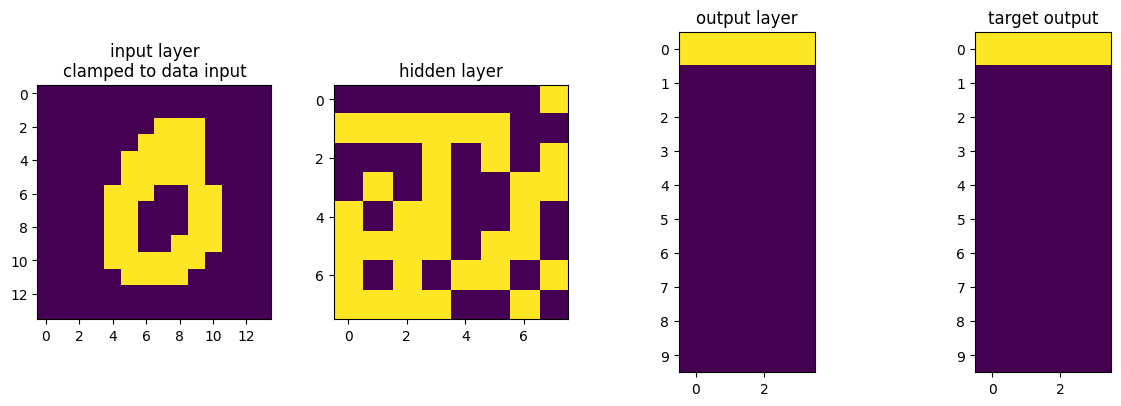

MovieWriter ffmpeg unavailable; using Pillow instead.


In [6]:
images = [configs[ :, : i_s ].reshape(-1, 14, 14),\
          configs[ :, i_s : i_s + h_s ].reshape(-1, 8,8),\
          configs[ :, -o_s: ].reshape(-1, 10,4),\
          truths.reshape(-1, 10, 4)]
titles = ['input layer\nclamped to data input', 'hidden layer', 'output layer', 'target output']
x_tickss = [np.arange(0, 14, 2), np.arange(0, 8, 2), np.arange(0, 4, 2), np.arange(0, 4, 2)]
y_tickss = [np.arange(0, 14, 2), np.arange(0, 8, 2), np.arange(0, 10, 1), np.arange(0, 10, 1)]

layout = [[0,1,2, 3]]
fig, ax = plt.subplot_mosaic(layout, figsize=(12,4))

fig.tight_layout()
im = []
for i in range(len(images)):
    im.append(ax[i].imshow(images[i][0]))
    #ax[i].imshow(images[i])
    ax[i].set_title(titles[i])
    ax[i].set_xticks(x_tickss[i])
    ax[i].set_yticks(y_tickss[i])
plt.show()


def update(frame):
    for i in range(len(images)):
        im[i].set_array(images[i][frame])
        if i == 2:
            ax[i].set_ylabel(f'predicted value: {truth_idxs[frame]}', fontsize=15)

        #ax[i].imshow()
        #ax[i].set_title(titles[i])
        #ax[i].set_xticks(x_tickss[i])
        #new_data = np.random.rand(10, 10)
    return tuple(im[i] for i in range(len(im)))


anim = FuncAnimation(fig, update, frames=len(configs), interval=500, blit=True)
anim.save('./anim2.gif', writer='ffmpeg', dpi=200)
plt.show()

In [ ]:
print()

-402566.38381682255


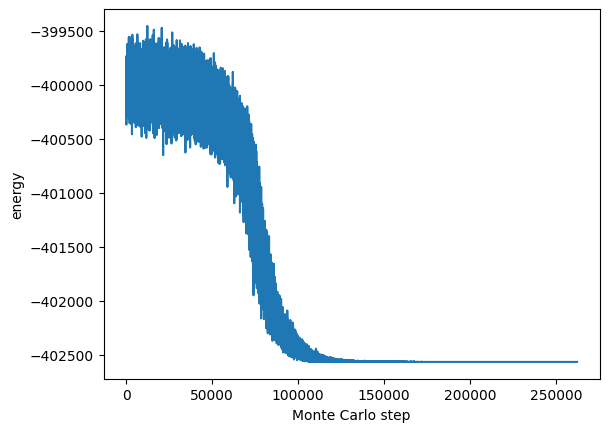

In [47]:
plt.plot(range(len(energies)), energies)
plt.xlabel('Monte Carlo step')
plt.ylabel('energy')
E = np.array(energies)
print(np.min(E))
plt.show()